# Assignment 2 - Exercise 3

Running this notebook requires you to have Numpy, Seaborn, and SciKit-Learn installed on your machine.

In [ ]:
# Imports
import itertools

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import mean_squared_error, accuracy_score

In [ ]:
# Load the Iris Dataset from SKLearn
iris = load_iris()

train_x = iris['data']
train_x = preprocessing.normalize(train_x) # normalize

train_y = iris['target']

In [ ]:
# Fit a KMeans estimator on the train data
est = KMeans(n_clusters=3)
est.fit(train_x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

NOTE: We have observed that the KMeans algorithm randomly assigns labels 0-2 to the clusters. Therefore, they may not map correctly to the labels given in the data. Hence, we employ a little trick to try out all possible permutations of the sequence `[1,2,3]`. The one with highest accuracy is assumed to be the correct label mapping.

In [ ]:
def calc_accuracy(yhat, y):
    """ Calculate the accuracy score between predicted and
    actual labels, when the correct mapping of the labels
    is not known. Tries out all possible permutations and
    return the highest accuracy score. """
    
    accuracy = 0  

    # Loop through all possible permutations
    for order in list(itertools.permutations([0, 1, 2])):

        # Decode the labels according to the order
        decoded_yhat = np.choose(yhat, order).astype(np.int64)

        # Compute accuracy
        new_accuracy = accuracy_score(decoded_yhat, y)

        # If accuracy is larger, replace
        if new_accuracy > accuracy:
            accuracy = new_accuracy

    return accuracy

In [ ]:
print(calc_accuracy(est.labels_, train_y))

0.9732142857142857


## PSO Algorithm

In the following you can find our implementation of the Canonical Particle Swarm Optimization Algorithm, used for data clustering. First are some helper functions, a function for computing the fitness (quantization error), and initializing a new population. Then, the main function `run_pso` which runs the PSO algorithm. The testing of the algorithm follows thereafter.

In [41]:
## Helper functions ##

def dist_func(z, x):
    """ Compute the Euclidean distance between two vectors
    z and x of equal dimension """
    return np.linalg.norm(z-x)

# Fix scalar values for the velocity updates
a1 = a2 = 1.49618
w = 0.7298

def update_v(v, x, lbest, gbest, r1, r2):
    """ Update the velocities of an individual cluster <x>. <v> is a list of the
    previous velocities in each dimension. <lbest> is the position of the
    locally best particle's cluster, <gbest> the one of the globally best. 
    <v>, <x>, <lbest>, and <gbest> need to one dimensional lists of equal length
    <r1> and <r2> are scalar values that should be drawn from a uniform dist.
    """
    return [ w*v[i] + a1*r1*(lbest[i] - x[i]) + a2*r2*(gbest[i] - x[i]) 
        for i in range(len(x))]

def update_pos(x, new_v):
    """ Update the position of a cluster <x> given some velocities <new_v>.
    <x> and <new_v> must be lists of scalars of equal length. """
    return [x[i] + new_v[i] for i in range(len(x))]

In [49]:
def get_quantization_error(data, particle, n_clusters):
    """ Compute the quantization error for a particle <particle> with
    <n_clusters> clusters, given data <data>. """
    
    # Collect cluster assignments
    clusters = []
    # Collect distances between cluster and data points for each cluster
    distances = np.zeros(n_clusters)

    # Loop through data
    for z in data:

        # Calculate distance of data point z to each cluster centroid
        dists = [dist_func(z, centroid) for centroid in particle]
        min_dist = min(dists)

        # Assign z to closest cluster
        cluster_id = dists.index(min_dist)

        # Collect 
        clusters.append(cluster_id)

        # Summing distance to each datapoint assigned to cluster
        distances[cluster_id] += min_dist

    # Given the cluster assignments and distances, calculate the fitness value
    # (or quantization error) for this particle
    fitness = 0

    # For each cluster
    for cluster_id in range(n_clusters):
        # Increase fitness by average distance per cluster
        fitness += (distances[cluster_id] / clusters.count(cluster_id))

    # Average over all clusters
    fitness = fitness / n_clusters

    return fitness

In [ ]:
def initialize_population(data, n_clusters, pop_size=100):
    """ Initialize a population of particles that act as individual solutions to 
    the optimization problem. One particle contains <n_clusters> clusters, that
    each contain as many values as a single datapoint in the data has dimensions
    """ 

    # Collect particles
    particles = []
    
    for n in range(pop_size):
        # Get all possible indexes
        indexes = np.arange(data.shape[0])
        # Choose <n_cluster> indexes randomly
        chosen_indexes = np.random.choice(indexes, n_clusters, replace=False)
        # Initialize the particle's cluster with randomly chosen datapoints
        particles.append(data[chosen_indexes])

    # Convert to Numpy array
    particles = np.array(particles)   

    # Initially, the locally best particles are just the initial particles
    local_best_particles = particles.copy()

    # For every particle, the best fitnesses are infinity since we want to 
    # minimize fitness
    local_best_fitnesses = np.full(pop_size, np.inf)
    
    # Choose velocities randomly from Normal distribution
    # We need a single velocity value for each dimension of each datapoint
    velocities = np.random.normal(0, 0.2, (pop_size, n_clusters, data.shape[-1]))

    return particles, local_best_particles, local_best_fitnesses, velocities

In [57]:
def run_pso(data, n_clusters, maxiter=200):
  """ Run the PSO Algorithm for <maxiter> iterations on the data <data>. 
  <n_clusters> determines how many clusters to use for each particle. 
  Return the global best particle and its fitness value after the optimization
  finished. 
  """
  
  # Since the fitness should be minimized, set its initial value to infinity
  global_best_fitness = np.inf

  # Initialize the population
  particles, local_best_particles, local_best_fitnesses, velocities = \
    initialize_population(data, n_clusters)

  # Iterate the algorithm
  for i in range(maxiter):
      
      print('Progress: {}/{}\r'.format(i+1,maxiter), end='\n')
      
      ## Compute particle fitness ## 

      # Collect fitnesses for this step to maybe update global best
      fitnesses = []

      # For each particle
      for j, particle in enumerate(particles):

          # Get the quantization error and use it as fitness to be minimized
          fitness = get_quantization_error(data, particle, n_clusters)
          
          # Update local best version of this particle if fitness has improved
          if fitness < local_best_fitnesses[j]:
              local_best_particles[j] = particle.copy()
              local_best_fitnesses[j] = fitness

          fitnesses.append(fitness)

      ## Update global best ## 

      # Potential candidate for the new global best is the minimum 
      # of the current step's fitnesses
      _new_best_fitness = np.min(fitnesses)

      # If it is an improvement compared to the previous global best
      if _new_best_fitness < global_best_fitness:

          # Update the global best
          global_best_fitness = _new_best_fitness
          global_best = particles[np.argmin(fitnesses)].copy()
      
      ## Move the particles for this step ##

      # Choose parameters randomly
      r1 = np.random.uniform()
      r2 = np.random.uniform()
      
      # For each particle
      for pidx in range(len(particles)):

          # For each cluster in particle
          for cidx in range(len(particles[pidx])):

              # Get velocity updates for this cluster
              velocities[pidx,cidx] = update_v(
                  velocities[pidx, cidx], 
                  particles[pidx, cidx], 
                  local_best_particles[pidx, cidx], 
                  global_best[cidx], r1, r2)
              
              # Move cluster using new velocities
              particles[pidx][cidx] = update_pos(
                  particles[pidx][cidx], 
                  velocities[pidx,cidx])
                       
  return global_best, global_best_fitness

After defining the algorithm above, we can now run it on the data, using 3 clusters. `max_iter` uses the default value.

In [ ]:
global_best, quantization_error = run_pso(train_x, 3)

Here we define a little helper function that allows us to get the labels for each datapoint corresponding to the closest cluster in the particle.

In [82]:
def get_labels(data, particle):
    """ Get the assigned cluster labels for each datapoint for a particle's
    clusters. """
    labels = []
    for z in data:
        dists = [dist_func(z, centroid) for centroid in particle]
        labels.append(np.argmin(dists)) # label is index for closest cluster
    return labels

In [83]:
# Get the labels for the globally best particle
labels = get_labels(train_x, global_best)

# Show the accuracy for this particle, along with the quantization error
accuracy = calc_accuracy(labels, train_y)
print("Accuracy:", accuracy)
print("Quantization Error:", quantization_error)

Accuracy: 0.9642857142857143
Quantization Error: 0.04111037943666631


Please note that the quantization error deviates from the one in the paper, as our data is normalized to allow comparison with KMeans. Further below, you will find a non-normalized fit.

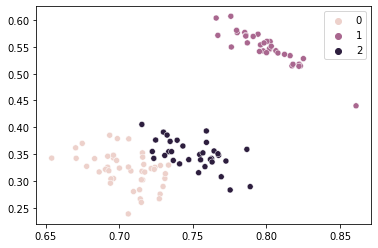

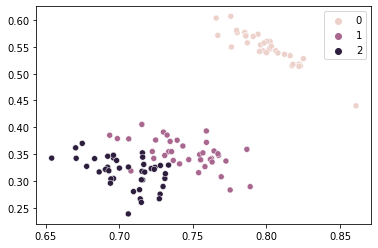

In [85]:
plt.title('PSO Clusters')
sb.scatterplot(x=train_x[:,0], y=train_x[:,1], hue=labels)
plt.show()
plt.title('True Clusters')
sb.scatterplot(x=train_x[:,0], y=train_x[:,1], hue=train_y)
plt.show()

Let's compare the quantization error of the PSO algorithm against KMeans.

In [88]:
print(get_quantization_error(train_x, global_best, n_clusters=3))
print(get_quantization_error(train_x, est.cluster_centers_, n_clusters=3))

0.04111037943666631
0.04127721277014537


In order to compare our results to that in the paper, we fit our PSO algorithm on a non-normalized version of the Iris dataset.

In [96]:
# Load Iris again, without normalization
iris = load_iris()
train_x = iris['data']
train_y = iris['target']

In [ ]:
global_best, quantization_error = run_pso(train_x, 3)

In [98]:
labels = get_labels(train_x, global_best)
accuracy = calc_accuracy(labels, train_y)
print("Accuracy:", accuracy)
print("Quantization Error:", quantization_error)

Accuracy: 0.5535714285714286
Quantization Error: 0.5982178077248482


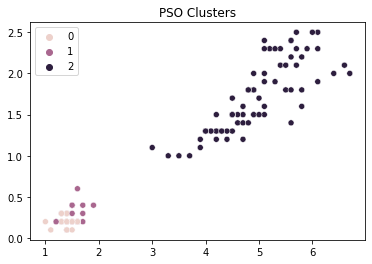

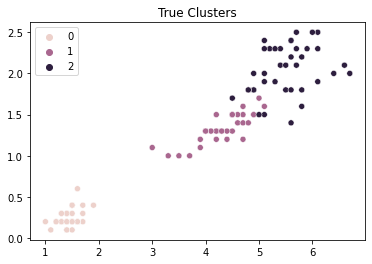

In [102]:
plt.title('PSO Clusters')
sb.scatterplot(x=train_x[:,2], y=train_x[:,3], hue=labels)
plt.show()
plt.title('True Clusters')
sb.scatterplot(x=train_x[:,2], y=train_x[:,3], hue=train_y)
plt.show()

In the following, we will fit the KMeans model as well as our PSO model on the artificial dataset as described in the paper. For this, define a function `generate_problem_data` which generates this data for us:

In [103]:
def generate_problem_data():
    """ Generate an artificial dataset for clustering experiments. """
    x = np.random.uniform(-1, 1, size=(400, 2))
    y = [1 if item[0] >= 0.7 or (item[0] <= 0.3 and item[1] >= -0.2 - item[0]) else 0 for item in x]
    return x, y

In [104]:
# Get the data
train_x, train_y = generate_problem_data()

In [105]:
# Fit KMeans
est = KMeans(n_clusters=2)
est.fit(train_x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
# Fit PSO
global_best, quantization_error = run_pso(train_x, 2)

In [111]:
# Get labels for PSO
labels = get_labels(train_x, global_best)

In [122]:
# Compare accuracy and quantization error of PSO vs. KMeans
pso_accuracy = calc_accuracy(labels, train_y)
kmeans_accuracy = calc_accuracy(est.labels_, train_y)
print("PSO Accuracy:\t\t", pso_accuracy)
print("KMeans Accuracy:\t", kmeans_accuracy)
print()
print("PSO Quant. Error:\t", quantization_error)
print("KMeans Quant. Error:\t", get_quantization_error(
    train_x, est.cluster_centers_, 2))

PSO Accuracy:		 0.5075
KMeans Accuracy:	 0.5525

PSO Quant. Error:	 0.5501989253959256
KMeans Quant. Error:	 0.5658695597250429


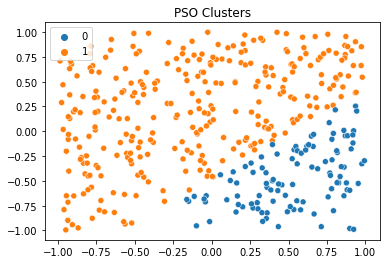

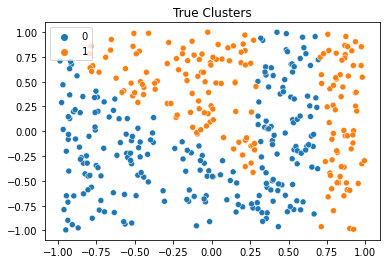

In [124]:
plt.title('PSO Clusters')
sb.scatterplot(x=train_x[:,0], y=train_x[:,1], hue=labels)
plt.show()
plt.title('True Clusters')
sb.scatterplot(x=train_x[:,0], y=train_x[:,1], hue=train_y)
plt.show()

From these results, we conclude:
- we normalized our data to compare it to a succesful k-means clustering, as kmeans needs normalized data
- to compare it to the paper data, we made a none normalized fit. Our quantization error is slightly better than the error reported in the paper.
- we observe that sometimes PSO finds clusters that differ from the original clusters, while still achieving a good fitness score. We believe this is because the quantization error is less sensitive to the cluster size than kmeans with summed errors.
- kmeans is better on iris (normalized)
- PSO is better on the artificial problem
- but since there cannot be a good solution to the artificial problem, quantization error is less informative